In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from skimage import color
from skimage.restoration import wiener
from scipy.signal import convolve as conv
from scipy.stats import multivariate_normal as multi_normal
numpy.random.seed(0)

Load the image. We will use a ground truth image for this task (instead of an *intensity* image) since the impact of deconvolution is better visible when a *binary* image is used.

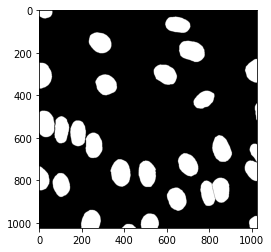

In [3]:
img = imread(f'../data/NIH3T3/gt/0.png')[:, :1024]
imshow(img, 'gray')

**Task 1** Apply the following PSF to the image and display it

In [4]:
psf_size = 20
psf = numpy.ones((psf_size, psf_size)) / psf_size**2

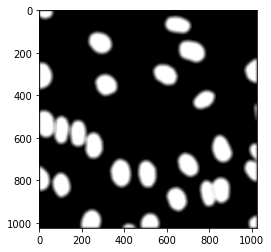

In [5]:
img_psf = conv(img, psf, 'same')
imshow(img_psf, 'gray')

**Task 2** Have a look at the Gaussian PSF which is not uniformly distributed.

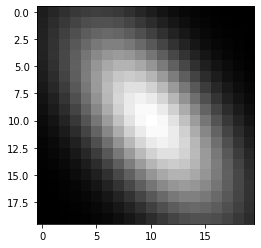

In [6]:
def create_psf(size):
    factor = size*1.8
    x, y = numpy.mgrid[0:size:1, 0:size:1]
    pos = numpy.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multi_normal([int(size/2), (int(size/2))], [[factor*1., factor*1.2], [factor*.5, factor*.7]])
    return rv.pdf(pos)

imshow(create_psf(psf_size), 'gray')

Apply the Gaussian PSF to the image:

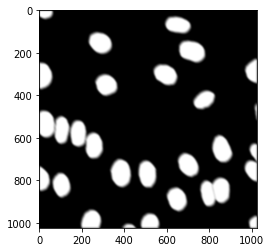

In [7]:
psf_2 = create_psf(psf_size)

img_psf_2 = conv(img, psf_2, 'same')
imshow(img_psf_2, 'gray')

**Task 3** Implement a reusable function that does the Richardson-Lucy deconvolution.

In [8]:
def richardson_lucy_deconvolution(image, psf, n_iterations):
    img_deconv = numpy.full(image.shape, 0.5)
    psf_flip = numpy.flip(psf)

    for _ in range(n_iterations):
        conv_psf = conv(img_deconv, psf, mode='same')
        relative_blur = image / conv_psf
        img_deconv *= conv(relative_blur, psf_flip, mode='same')
    
    img_deconv[img_deconv > 1] = 1
    img_deconv[img_deconv < -1] = -1
    return img_deconv

**Task 4** Apply the Richardson-Lucy deconvolution to the blurred image.

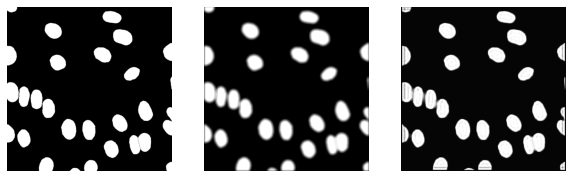

In [9]:
deconv_img = richardson_lucy_deconvolution(img_psf, psf, 20)

figure(figsize=(10,5))
subplot(1, 3, 1)
axis('off')
imshow(img, 'gray')
subplot(1, 3, 2)
axis('off')
imshow(img_psf, 'gray')
subplot(1, 3, 3)
axis('off')
imshow(deconv_img, 'gray')

**Task 5** Add noise to the image, use the R-L deconvolution again.

In [10]:
noise = (numpy.random.normal(loc=5,size=img.shape))
reduce_factor = 50
noise = noise / reduce_factor

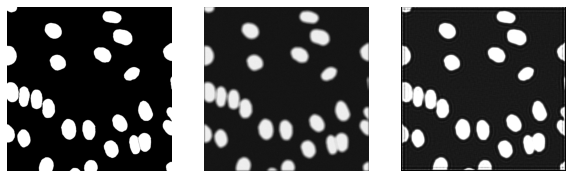

In [11]:
img_noisy = img_psf.copy()
img_noisy +=  noise
deconv_img_noisy = richardson_lucy_deconvolution(img_noisy, psf, 20)

figure(figsize=(10,5))
subplot(1, 3, 1)
axis('off')
imshow(img, 'gray')
subplot(1, 3, 2)
axis('off')
imshow(img_noisy, 'gray')
subplot(1, 3, 3)
axis('off')
imshow(deconv_img_noisy, 'gray')

**Task 6** Compare your R-L implementation to a Wiener deconvolution.

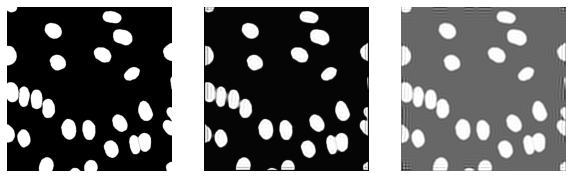

In [12]:
deconv_wiener = wiener(img_psf, psf, balance=2, clip=True)
figure(figsize=(10,5))
subplot(1, 3, 1)
axis('off')
imshow(img, 'gray')
subplot(1, 3, 2)
axis('off')
imshow(deconv_img, 'gray')
subplot(1, 3, 3)
axis('off')
imshow(deconv_wiener, 'gray')

**Task 7** Repeat Tasks 4–6 using a smaller value for the size of the PSF.

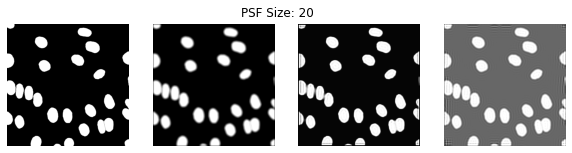

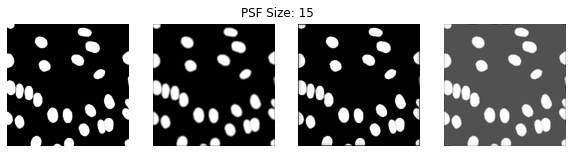

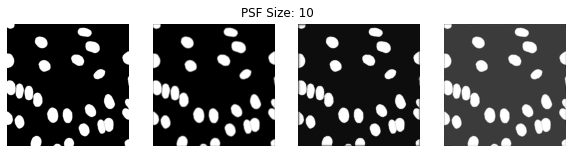

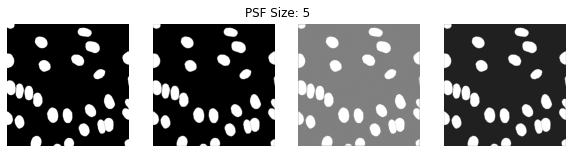

In [13]:
psf_sizes = [20,15,10,5]
for i in range(len(psf_sizes)):
    psf_it = numpy.ones((psf_sizes[i], psf_sizes[i])) / psf_sizes[i]**2 
    img_psf_it = conv(img, psf_it, 'same')
    deconv_rl_it = richardson_lucy_deconvolution(img_psf_it, psf_it, 20)
    deconv_wiener_it = deconv_wiener = wiener(img_psf_it, psf_it, balance=2, clip=True)
    figure(figsize=(10,5))
    suptitle(f'PSF Size: {psf_sizes[i]}')
    subplot(1, 4, 1)
    imshow(img, 'gray')
    axis('off')
    subplot(1, 4, 2)
    axis('off')
    imshow(img_psf_it, 'gray')
    subplot(1, 4, 3)
    axis('off')
    imshow(deconv_rl_it, 'gray')
    subplot(1, 4, 4)
    axis('off')
    imshow(deconv_wiener_it, 'gray')
    subplots_adjust(top=1.4)

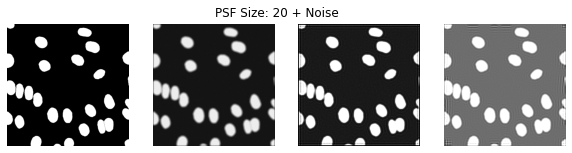

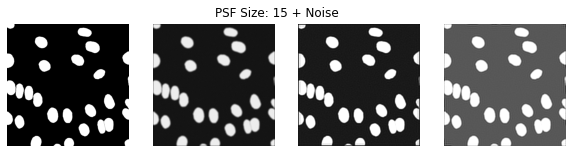

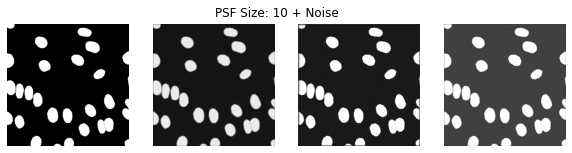

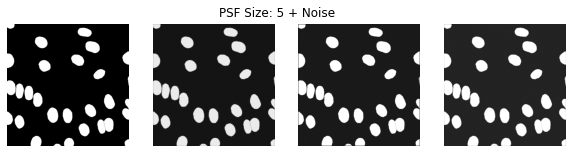

In [14]:
noise = (numpy.random.normal(loc=5,size=img.shape))
reduce_factor = 50
noise = noise / reduce_factor
psf_sizes = [20,15,10,5]
for i in range(len(psf_sizes)):
    psf_it = numpy.ones((psf_sizes[i], psf_sizes[i])) / psf_sizes[i]**2 
    img_psf_it = conv(img, psf_it, 'same')
    img_psf_it += noise
    deconv_rl_it = richardson_lucy_deconvolution(img_psf_it, psf_it, 20)
    deconv_wiener_it = deconv_wiener = wiener(img_psf_it, psf_it, balance=2, clip=True)
    figure(figsize=(10,5))
    suptitle(f'PSF Size: {psf_sizes[i]} + Noise')
    subplot(1, 4, 1)
    imshow(img, 'gray')
    axis('off')
    subplot(1, 4, 2)
    axis('off')
    imshow(img_psf_it, 'gray')
    subplot(1, 4, 3)
    axis('off')
    imshow(deconv_rl_it, 'gray')
    subplot(1, 4, 4)
    axis('off')
    imshow(deconv_wiener_it, 'gray')
    subplots_adjust(top=1.4)

**Task 8** Use the wrong PSF to reconstruct the image.

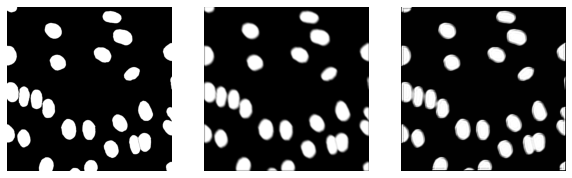

In [15]:
deconv_img_wrong = richardson_lucy_deconvolution(img_psf, psf_2, 20)

plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(img_psf_2, 'gray')
plt.subplot(1, 3, 3)
plt.axis('off')
imshow(deconv_img_wrong, 'gray')

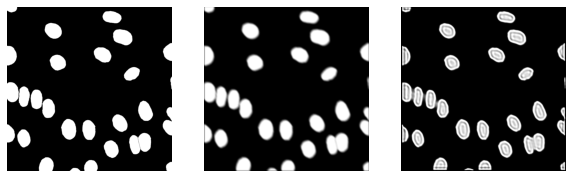

In [16]:
deconv_img_wrong_2 = richardson_lucy_deconvolution(img_psf_2, psf, 20)

plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(img_psf_2, 'gray')
plt.subplot(1, 3, 3)
plt.axis('off')
imshow(deconv_img_wrong_2, 'gray')